In [37]:
####### CURIAL-Federated Learning Study Results Processing #######

In [77]:
import sys
import warnings
import flwr as fl
from sklearn.metrics import log_loss
from typing import Dict
import numpy as np
import pandas as pd
from typing import List, Tuple, Optional, Dict
import openpyxl
import shap
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, recall_score, precision_score, accuracy_score,roc_auc_score, confusion_matrix, roc_curve
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from scipy.special import ndtri
import math
import pickle
import json

import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model

import random
import os
import time
import matplotlib.pyplot as plt

import utils

In [78]:
###########################################
###
###  A) XAI: Plot Explainable AI analyses
###     Feature importance analyses
###
###########################################

In [79]:
#Define Feature List
featureList = pd.Series(['ALBUMIN', 'ALK.PHOSPHATASE', 'ALT', 'BASOPHILS', 'BILIRUBIN', 'CREATININE', 'CRP', 'EOSINOPHILS', 'HAEMATOCRIT', 'HAEMOGLOBIN', 'LYMPHOCYTES', 'MEAN CELL VOL.', 'MONOCYTES', 'NEUTROPHILS', 'PLATELETS', 'POTASSIUM', 'SODIUM', 'UREA', 'WHITE CELLS', 'eGFR', 'Respiratory Rate', 'Heart Rate', 'Systolic Blood Pressure', 'Temperature Tympanic', 'Oxygen Saturation', 'Oxygen Delivery device used', 'Diastolic Blood Pressure'])

In [80]:
#Basepath for results directory
basepath='Results/'

In [81]:
#Load Final Global Models
with open(basepath+'SavedModel_LR Global Model.pkl', "rb") as input_file:
    LR_Global_Model = pickle.load(input_file)
with open(basepath+'SavedModel_DNN Global Model.pkl', "rb") as input_file:
    DNN_Global_Model = pickle.load(input_file)

2022-12-26 19:40:24.938330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-26 19:40:24.986214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


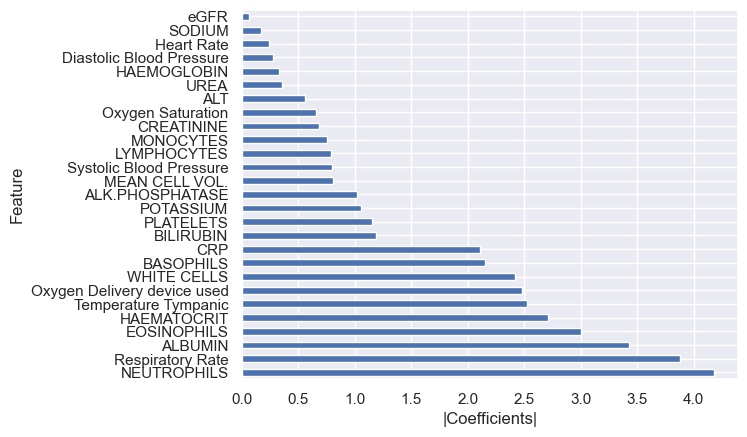

In [86]:
#Plot LR Global Model relative feature importances - coefficients as part of a total
shownumber = 40
w0 = LR_Global_Model.intercept_[0]
w = LR_Global_Model.coef_[0]
#Convert LR coefficients to scalars (remove vector/directionality)
feature_importance = pd.Series(abs(w), index=featureList).nlargest(shownumber).sort_values(ascending=False)
ax = feature_importance.plot.barh(x='feature', y='Scalar coefficients')
plt.ylabel("Feature")
plt.xlabel("|Coefficients|")
plt.show()

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


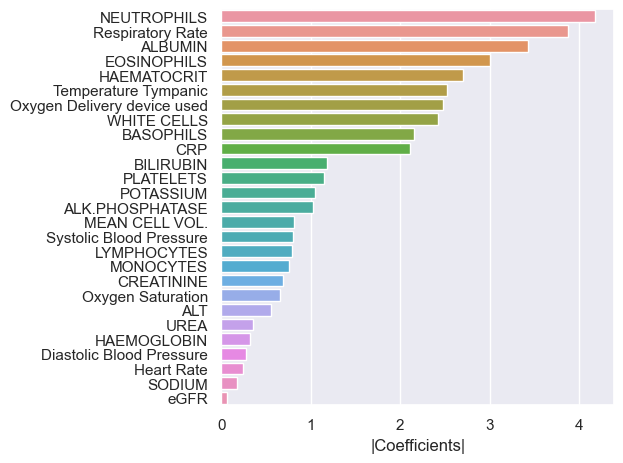

In [87]:
#Re-plot LR feature importances using seaborn, for improved colour
#plt.figure(figsize=(8,8))
sns.barplot(abs(feature_importance.values), feature_importance.index)
plt.xlabel('|Coefficients|')
#Save figure
plt.tight_layout()
plt.savefig('23-12-22 Figure 4 - Logistic Regression Global Model Relative Importances.png', dpi=500)

In [89]:
#Save CSV of feature_impostances
feature_importance.to_csv("23-12-22 Figure 4 - Logistic Regression - Global Model Relative Importances.csv")

In [90]:
#### SHAP analyses

In [91]:
#Load in global model SHAP values results
with open(basepath+'shapExplanations_LR_final_global_model.pkl', "rb") as input_file:
    LR_Global_model_final_SHAP = pickle.load(input_file)
with open(basepath+'shapExplanations_DNN_final_global_model.pkl', "rb") as input_file:
    DNN_Global_model_final_SHAP = pickle.load(input_file)

#Load in round 0 explainability analyses
# #LR
# with open(r'shapExplanations_LR_OUH 0th iteration.pkl', "rb") as input_file:
#     LR_OUH = pickle.load(input_file)
# with open(r'shapExplanations_LR_PUH 0th iteration.pkl', "rb") as input_file:
#     LR_PUH = pickle.load(input_file)
# with open(r'shapExplanations_LR_UHB 0th iteration.pkl', "rb") as input_file:
#     LR_UHB = pickle.load(input_file)

#DNN
# DNN_OUH = pickle.load('shapExplanations_DNN_OUH 0th iteration.pkl')
# DNN_PUH = pickle.load('shapExplanations_DNN_PUH 0th iteration.pkl')
# DNN_UHB = pickle.load('shapExplanations_DNN_UHB 0th iteration.pkl')

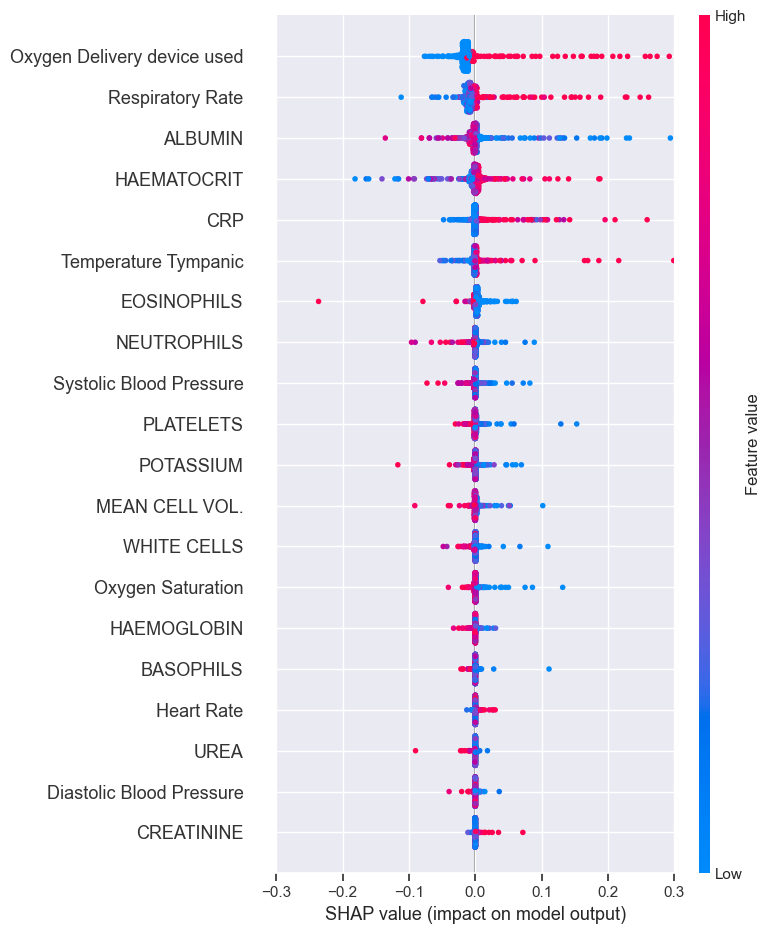

In [92]:
#LR SHAP Plot
shap.summary_plot(LR_Global_model_final_SHAP, feature_names=featureList, show=False)
ax = plt.gca()
ax.set_xlim(-0.3,0.3) 
plt.show()

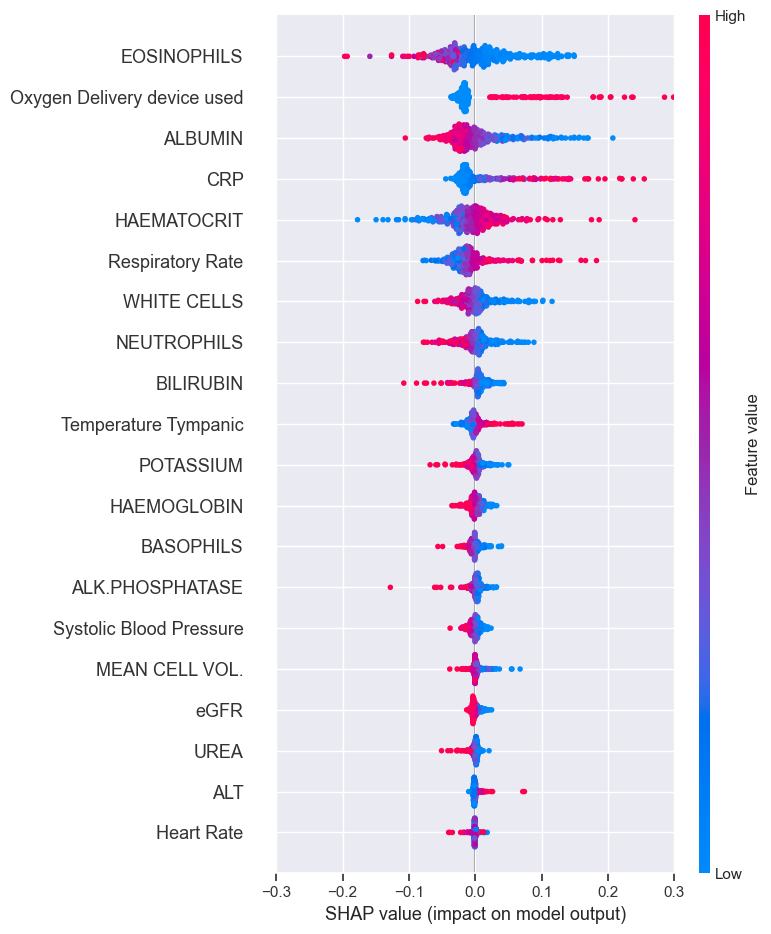

In [93]:
#DNN SHAP plot
shap.summary_plot(DNN_Global_model_final_SHAP, feature_names=featureList, show=False)
ax = plt.gca()
ax.set_xlim(-0.3,0.3) 
plt.show()

In [94]:
###########################################
###
###  A) ROC CURVES: Plot ROC Curves
###
###########################################

## NB: Consider adding curve for after 1 round of federation - versus after 150 rounds of federation

In [95]:
# First, we seek to plot a figure that shows the value add of performing Federated learning
# To do this, we compare ROC curves for models trained ONLY on the individual site's data with ROC curves for the Global Model
# The aim is to produce a 3x2 Grid showing ROC curves for DNN + LR, at OUH, PUH, UHB

In [96]:
#Import ROC curves
LRLocalModelsROC = pd.read_csv(basepath+"LR First Round ROC curves - Results collated on server.csv")
LRGlobalModelsROC = pd.read_csv(basepath+"LR ROC analysis - Results collated on server.csv")
DNNLocalModelsROC = pd.read_csv(basepath+"DNN First Round ROC curves - Results collated on server.csv")
DNNGlobalModelsROC = pd.read_csv(basepath+"DNN ROC analysis - Results collated on server.csv")

In [97]:
#Define TPR and FPR for each site
#First - Logistic Regression
OUHLocalLR_TPR = LRLocalModelsROC['OUH'][2:].dropna().astype(float).rename("LR") #NB: This is the True Positive Rate; LR used to display desired lable
OUHLocalLR_FPR = LRLocalModelsROC['OUH.1'][2:].dropna().astype(float).rename("False Positive Rate")
OUHGlobalLR_TPR = LRGlobalModelsROC['OUH'][2:].dropna().astype(float).rename("LR")
OUHGlobalLR_FPR = LRGlobalModelsROC['OUH.1'][2:].dropna().astype(float).rename("False Positive Rate")

PUHLocalLR_TPR = LRLocalModelsROC['PUH'][2:].dropna().astype(float).rename("LR")
PUHLocalLR_FPR = LRLocalModelsROC['PUH.1'][2:].dropna().astype(float).rename("False Positive Rate")
PUHGlobalLR_TPR = LRGlobalModelsROC['PUH'][2:].dropna().astype(float).rename("LR")
PUHGlobalLR_FPR = LRGlobalModelsROC['PUH.1'][2:].dropna().astype(float).rename("False Positive Rate")

UHBLocalLR_TPR = LRLocalModelsROC['UHB'][2:].dropna().astype(float).rename("LR")
UHBLocalLR_FPR = LRLocalModelsROC['UHB.1'][2:].dropna().astype(float).rename("False Positive Rate")
UHBGlobalLR_TPR = LRGlobalModelsROC['UHB'][2:].dropna().astype(float).rename("LR")
UHBGlobalLR_FPR = LRGlobalModelsROC['UHB.1'][2:].dropna().astype(float).rename("False Positive Rate")

#DNN
OUHLocalDNN_TPR = DNNLocalModelsROC['OUH'][2:].dropna().astype(float).rename("DNN")
OUHLocalDNN_FPR = DNNLocalModelsROC['OUH.1'][2:].dropna().astype(float).rename("False Positive Rate")
OUHGlobalDNN_TPR = DNNGlobalModelsROC['OUH'][2:].dropna().astype(float).rename("DNN")
OUHGlobalDNN_FPR = DNNGlobalModelsROC['OUH.1'][2:].dropna().astype(float).rename("False Positive Rate")

PUHLocalDNN_TPR = DNNLocalModelsROC['PUH'][2:].dropna().astype(float).rename("DNN")
PUHLocalDNN_FPR = DNNLocalModelsROC['PUH.1'][2:].dropna().astype(float).rename("False Positive Rate")
PUHGlobalDNN_TPR = DNNGlobalModelsROC['PUH'][2:].dropna().astype(float).rename("DNN")
PUHGlobalDNN_FPR = DNNGlobalModelsROC['PUH.1'][2:].dropna().astype(float).rename("False Positive Rate")

UHBLocalDNN_TPR = DNNLocalModelsROC['UHB'][2:].dropna().astype(float).rename("DNN")
UHBLocalDNN_FPR = DNNLocalModelsROC['UHB.1'][2:].dropna().astype(float).rename("False Positive Rate")
UHBGlobalDNN_TPR = DNNGlobalModelsROC['UHB'][2:].dropna().astype(float).rename("DNN")
UHBGlobalDNN_FPR = DNNGlobalModelsROC['UHB.1'][2:].dropna().astype(float).rename("False Positive Rate")

Text(0.5, 1.0, 'UHB - Test set')

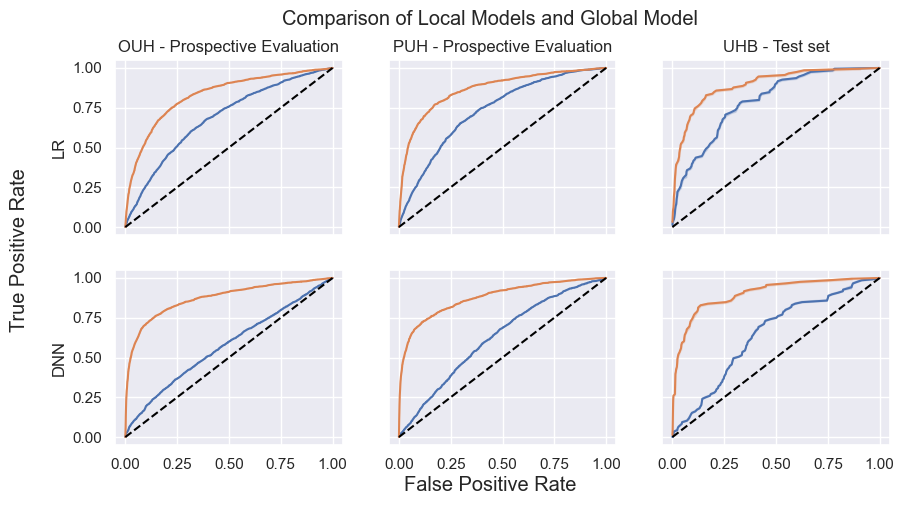

In [98]:
#Produce a plot of Local Model vs Global Model
#NB: This is very slow to run

sns.set()
fig, axes = plt.subplots(2, 3, sharey=True, sharex=True, figsize=(10,5))
fig.suptitle('Comparison of Local Models and Global Model')
fig.supylabel('True Positive Rate')
fig.supxlabel('False Positive Rate')

#Plot OUH
sns.lineplot(ax=axes[0,0], x=OUHLocalLR_FPR.values, y=OUHLocalLR_TPR)
sns.lineplot(ax=axes[0,0], x=OUHGlobalLR_FPR.values, y=OUHGlobalLR_TPR)
sns.lineplot(ax=axes[0,0], x=[0, 1], y=[0, 1], color='black', linestyle='--')
sns.lineplot(ax=axes[1,0], x=OUHLocalDNN_FPR.values, y=OUHLocalDNN_TPR)
sns.lineplot(ax=axes[1,0], x=OUHGlobalDNN_FPR.values, y=OUHGlobalDNN_TPR)
sns.lineplot(ax=axes[1,0], x=[0, 1], y=[0, 1], color='black', linestyle='--')

#Plot PUH
sns.lineplot(ax=axes[0,1], x=PUHLocalLR_FPR.values, y=PUHLocalLR_TPR)
sns.lineplot(ax=axes[0,1], x=PUHGlobalLR_FPR.values, y=PUHGlobalLR_TPR)
sns.lineplot(ax=axes[0,1], x=[0, 1], y=[0, 1], color='black', linestyle='--')
sns.lineplot(ax=axes[1,1], x=PUHLocalDNN_FPR.values, y=PUHLocalDNN_TPR)
sns.lineplot(ax=axes[1,1], x=PUHGlobalDNN_FPR.values, y=PUHGlobalDNN_TPR)
sns.lineplot(ax=axes[1,1], x=[0, 1], y=[0, 1], color='black', linestyle='--')

#Plot UHB
sns.lineplot(ax=axes[0,2], x=UHBLocalLR_FPR.values, y=UHBLocalLR_TPR)
sns.lineplot(ax=axes[0,2], x=UHBGlobalLR_FPR.values, y=UHBGlobalLR_TPR)
sns.lineplot(ax=axes[0,2], x=[0, 1], y=[0, 1], color='black', linestyle='--')
sns.lineplot(ax=axes[1,2], x=UHBLocalDNN_FPR.values, y=UHBLocalDNN_TPR)
sns.lineplot(ax=axes[1,2], x=UHBGlobalDNN_FPR.values, y=UHBGlobalDNN_TPR)
sns.lineplot(ax=axes[1,2], x=[0, 1], y=[0, 1], color='black', linestyle='--')

plt.xticks(np.arange(0, 1.05, step=0.25))
plt.yticks(np.arange(0, 1.05, step=0.25))
axes[0,0].set_title("OUH - Prospective Evaluation")
axes[0,1].set_title("PUH - Prospective Evaluation")
axes[0,2].set_title("UHB - Test set")

In [101]:
#Save figure
fig.savefig('23-12-22 Figure 2 - Comparison of Local and Global Models ROC Curves.png', dpi=500)

In [102]:
#Explort SVG for journal
fig.savefig('23-12-22 Figure 2 - Comparison of Local and Global Models ROC Curves.svg', dpi=500)

In [103]:
#############################################
###
###  B) PLOT SUMMARY RESULTS TABLE FOR KEY MODELS
###
###########################################

In [104]:
#Load in Results Files
LRGlobalFederationResults = pd.read_csv(basepath+"LR Global Model Federated Evaluation - Results collated on server.csv", index_col=0, header=[0,1])
LRSitePersonalisedFederationResults = pd.read_csv(basepath+"LR Site Personalised Federated Evaluation - Results collated on server.csv", index_col=0, header=[0,1])
DNNGlobalFederationResults = pd.read_csv(basepath+"DNN Global Model Federated Evaluation - Results collated on server.csv", index_col=0, header=[0,1])
DNNSitePersonalisedFederationResults = pd.read_csv(basepath+"DNN Site Personalised Federated Evaluation - Results collated on server.csv", index_col=0, header=[0,1])

In [105]:
# Generate Table 2
#Now generate Table 2 - results of round 0 + 150 for LR and DNN, site personalised where applicable
sites = ['OUH','PUH','BHEvaluation']
outputDf = pd.DataFrame(columns=['AUROC', 'Achieved Sensitivity', 'Specificity', 'Accuracy', 'Precision',
       'NPV', 'F1'])

for site in sites:
    #Order of output is to be a) LR: Local Model, b) LR: Global Model, c)LR site personalised
    
    #The 'iter 0' model for BH in infact the iter 1 of the global model - not a local model - (as round 0 here is application of the GM, and initialised with Global model params)
    if not (site =='BHEvaluation'):
        #Add in LR Local Model
        outputDf.loc[site+' LR Local Model']= LRGlobalFederationResults[site].loc[0]
        
    #Add in LR Global Model (i.e. last value in the Global file)
    outputDf.loc[site+' LR Global Model']= LRGlobalFederationResults[site].iloc[-1]
    
    #Where relevant, add site specific model
    try:
        #Add in LR Site Personalised (i.e. last value in the Global file)
        outputDf.loc[site+' LR Site-Personalised Model']= LRSitePersonalisedFederationResults[site].iloc[-1]
    except:
        pass
    
    #The 'iter 0' model for BH in infact the iter 1 of the global model - not a local model - (as round 0 here is application of the GM, and initialised with Global model params)
    if not (site =='BHEvaluation'):
        #Add in LR Local Model
        outputDf.loc[site+' DNN Local Model']= DNNGlobalFederationResults[site].loc[0]
            
    #Add in LR Global Model (i.e. last value in the Global file)
    outputDf.loc[site+' DNN Global Model']= DNNGlobalFederationResults[site].iloc[-1]

    #Where relevant, add site specific model
    try:
        #Add in LR Site Personalised (i.e. last value in the Global file)
        outputDf.loc[site+' DNN Site-Personalised Model']= DNNSitePersonalisedFederationResults[site].iloc[-1]
    except:
        pass

#Last, round the F1 column to 2 decimal places for tidyness
outputDf['F1'] = outputDf['F1'].astype(float).round(decimals=3)

#Make a copy out outputDf in a variable called Table 2
table2 = outputDf

In [106]:
outputDf.to_csv('23-12-22 Table 3 - Summary Results of Federation.csv')

In [107]:
##########################
##### MANUAL PROCESSING STEP - Use output of table 2 to complete Graphpad prism & Graph the final results

In [114]:
#############################################
###
###  C) Federation Curves - Plot FL advantage curves of AUROC versus rounds of Federated Training
###     Include 95% CIs
###########################################

In [115]:
#Split AUC in to 3 columns
def AUCSplitter (AUCHwith95CI):
    AUC = [float(x.split(' (')[-0]) for x in AUCHwith95CI]
    part2 = [x.split(' (')[-1] for x in AUCHwith95CI]
    AUC_lower95 = [float(x.split(' - ')[-0]) for x in part2]
    part3 = [x.split(' - ')[-1] for x in part2]
    AUC_upper95 = [float(x.split(')')[-0]) for x in part3]
    
    return AUC, AUC_lower95, AUC_upper95, AUCHwith95CI

In [116]:
#Cycle through the sites to split out the AUROC column in to AUC, _lower95 and _upper95
for name, resultsSheet in enumerate([LRGlobalFederationResults, LRSitePersonalisedFederationResults, DNNGlobalFederationResults, DNNSitePersonalisedFederationResults]):
    for site in ['OUH','PUH','BHEvaluation','UHB']:
        try: 
            resultsSheet[site,'AUROC'], resultsSheet[site,'AUROC_lower95'], resultsSheet[site,'AUROC_upper95'], resultsSheet[site,'AUROC_formatted'] = AUCSplitter(resultsSheet[site,'AUROC'])
        except:
            print ('Not all sites found in all results files')
    resultsSheet.sort_index(axis=1, level=0, inplace=True)

Not all sites found in all results files
Not all sites found in all results files
Not all sites found in all results files
Not all sites found in all results files
Not all sites found in all results files
Not all sites found in all results files
Not all sites found in all results files
Not all sites found in all results files
Not all sites found in all results files
Not all sites found in all results files
Not all sites found in all results files
Not all sites found in all results files
Not all sites found in all results files
Not all sites found in all results files
Not all sites found in all results files
Not all sites found in all results files


In [117]:
#Prepare CSV outputs for Graphpad Prism
#LR Global AUROC, _u95, _l95 / Site personalised AUROC, _u95, _l95 || DNN Global AUROC, _u95, _l95 / Site personalised AUROC, _u95, _l95

sites = ['OUH','PUH','BHEvaluation','UHB']
#items = ['Global_LR_AUROC','Global_LR_AUROC_u95','Global_LR_AUROC_l95','Personalised_LR_AUROC','Personalised_LR_AUROC_u95','Personalised_LR_AUROC_l95','Global_DNN_AUROC','Global_DNN_AUROC_u95','Global_DNN_AUROC_l95','Personalised_DNN_AUROC','Personalised_DNN_AUROC_u95','Personalised_DNN_AUROC_l95']
##tuples=list(zip(sites,items))
#index = pd.MultiIndex.from_tuples(tuples, names=["Site","Metric"])
outputDf = pd.DataFrame(index=DNNGlobalFederationResults.index)

for site in sites:    
    #First place LR results for Global Model
    outputDf[site+' Global Model LR (AUROC)'] = LRGlobalFederationResults[site,'AUROC']
    outputDf[site+' Global Model LR (AUROC)_u95'] = LRGlobalFederationResults[site,'AUROC_upper95']
    outputDf[site+' Global Model LR (AUROC)_l95'] = LRGlobalFederationResults[site,'AUROC_lower95']
    #outputDf[site+' Global Model LR (AUROC) Formatted'] = LRGlobalFederationResults[site,'AUROC_formatted']
    
    #Now LR results for site personalised
    try:
        outputDf[site+' Site Tuned Model LR (AUROC)'] = LRSitePersonalisedFederationResults[site,'AUROC']
        outputDf[site+' Site Tuned Model LR (AUROC)_u95'] = LRSitePersonalisedFederationResults[site,'AUROC_upper95']
        outputDf[site+' Site Tuned Model LR (AUROC)_l95'] = LRSitePersonalisedFederationResults[site,'AUROC_lower95']
        #outputDf[site+' Site Tuned Model LR (AUROC) Formatted'] = LRSitePersonalisedFederationResults[site,'AUROC_formatted']
    except:
        print ("Processing dataset without site personalisation")
    
    #Next place DNN results for Global Model
    outputDf[site+' Global Model DNN (AUROC)'] = DNNGlobalFederationResults[site,'AUROC']
    outputDf[site+' Global Model DNN (AUROC)_u95'] = DNNGlobalFederationResults[site,'AUROC_upper95']
    outputDf[site+' Global Model DNN (AUROC)_l95'] = DNNGlobalFederationResults[site,'AUROC_lower95']
    #outputDf[site+' Global Model DNN (AUROC)_l95 Formatted'] = DNNGlobalFederationResults[site,'AUROC_formatted']

    #Now DNN results for site personalised
    try:
        outputDf[site+' Site Tuned Model DNN (AUROC)'] = DNNSitePersonalisedFederationResults[site,'AUROC']
        outputDf[site+' Site Tuned Model DNN (AUROC)_u95'] = DNNSitePersonalisedFederationResults[site,'AUROC_upper95']
        outputDf[site+' Site Tuned Model DNN (AUROC)_l95'] = DNNSitePersonalisedFederationResults[site,'AUROC_lower95']
        #outputDf[site+' Site Tuned Model LR (AUROC) Formatted'] = DNNSitePersonalisedFederationResults[site,'AUROC_formatted']
    except:
        print ("Processing dataset without site personalisation")
    
#Save outpout dataframe for importing in to PRISM
outputDf.to_csv('23-12-22 Figure 3 Evaluation Results for Plotting with Graphpad Prism.csv')

table3 = outputDf

Processing dataset without site personalisation
Processing dataset without site personalisation


In [118]:
#Show a table of global vs site-tuned models
table3.loc[:,table3.columns.str.endswith("(AUROC)")]

,OUH Global Model LR (AUROC),OUH Site Tuned Model LR (AUROC),OUH Global Model DNN (AUROC),OUH Site Tuned Model DNN (AUROC),PUH Global Model LR (AUROC),PUH Site Tuned Model LR (AUROC),PUH Global Model DNN (AUROC),PUH Site Tuned Model DNN (AUROC),BHEvaluation Global Model LR (AUROC),BHEvaluation Global Model DNN (AUROC),UHB Global Model LR (AUROC),UHB Site Tuned Model LR (AUROC),UHB Global Model DNN (AUROC),UHB Site Tuned Model DNN (AUROC)
Iteration,,,,,,,,,,,,,,
0,0.685,0.793,0.574,0.538,0.731,0.864,0.622,0.591,0.804,0.696,0.791,0.878,0.643,0.538
1,0.811,0.806,0.531,0.604,0.854,0.855,0.605,0.626,0.862,0.684,0.891,0.900,0.523,0.653
2,0.813,0.818,0.627,0.680,0.853,0.859,0.699,0.741,0.864,0.795,0.897,0.901,0.663,0.761
3,0.819,0.817,0.700,0.725,0.859,0.861,0.770,0.784,0.870,0.837,0.899,0.901,0.794,0.821
4,0.822,0.823,0.734,0.748,0.860,0.863,0.796,0.804,0.872,0.853,0.900,0.901,0.840,0.850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,0.828,0.829,0.872,0.872,0.864,0.867,0.876,0.883,0.877,0.917,0.896,0.900,0.901,0.902
147,0.828,0.828,0.872,0.872,0.865,0.867,0.876,0.883,0.878,0.917,0.896,0.900,0.901,0.902
148,0.828,0.830,0.872,0.872,0.864,0.867,0.876,0.883,0.877,0.917,0.896,0.901,0.902,0.903


Text(0.5, 1.0, 'BH - Prospective & External')

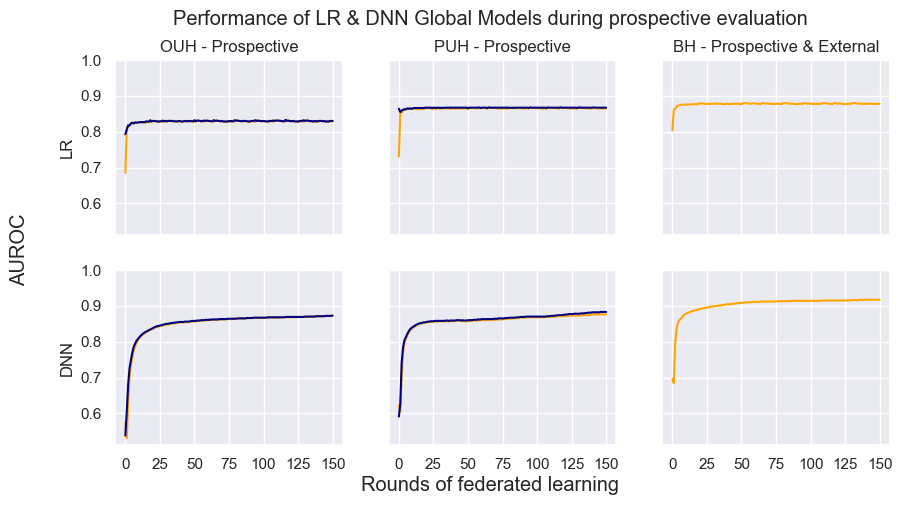

In [119]:
#Produce a plot of AUROC Local Model vs Global Model OVER ITERATIONS
sns.set()
sns.color_palette("muted")
fig, axes = plt.subplots(2, 3, sharey=True, sharex=True, figsize=(10,5))
fig.suptitle('Performance of LR & DNN Global Models during prospective evaluation')
fig.supylabel('AUROC')
fig.supxlabel('Rounds of federated learning')

#Plot OUH
sns.lineplot(ax=axes[0,0], x=table3.index.values, y=table3['OUH Global Model LR (AUROC)'].rename("LR"), color='orange')
sns.lineplot(ax=axes[0,0], x=table3.index.values, y=table3['OUH Site Tuned Model LR (AUROC)'], color='navy')
sns.lineplot(ax=axes[1,0], x=table3.index.values, y=table3['OUH Global Model DNN (AUROC)'].rename("DNN"), color='orange')
sns.lineplot(ax=axes[1,0], x=table3.index.values, y=table3['OUH Site Tuned Model DNN (AUROC)'].values, color='navy')

#Plot PUH
sns.lineplot(ax=axes[0,1], x=table3.index.values, y=table3['PUH Global Model LR (AUROC)'].values, color='orange')
sns.lineplot(ax=axes[0,1], x=table3.index.values, y=table3['PUH Site Tuned Model LR (AUROC)'].values, color='navy')
sns.lineplot(ax=axes[1,1], x=table3.index.values, y=table3['PUH Global Model DNN (AUROC)'].values, color='orange')
sns.lineplot(ax=axes[1,1], x=table3.index.values, y=table3['PUH Site Tuned Model DNN (AUROC)'].values, color='navy')

#Plot BH
sns.lineplot(ax=axes[0,2], x=table3.index.values, y=table3['BHEvaluation Global Model LR (AUROC)'].values, color='orange')
#sns.lineplot(ax=axes[0,0], x=table3.index.values, y=table3['BH Site Tuned Model LR (AUROC)'])
sns.lineplot(ax=axes[1,2], x=table3.index.values, y=table3['BHEvaluation Global Model DNN (AUROC)'].values, color='orange')
#sns.lineplot(ax=axes[1,0], x=table3.index.values, y=table3['BH Site Tuned Model DNN (AUROC)'])

#Plot UHB ON TEST SET
#sns.lineplot(ax=axes[0,3], x=table3.index.values, y=table3['UHB Global Model LR (AUROC)'].values, color='orange')
#sns.lineplot(ax=axes[0,3], x=table3.index.values, y=table3['UHB Site Tuned Model LR (AUROC)'])
#sns.lineplot(ax=axes[1,3], x=table3.index.values, y=table3['UHB Global Model DNN (AUROC)'].values, color='orange')
#sns.lineplot(ax=axes[1,3], x=table3.index.values, y=table3['UHB Site Tuned Model DNN (AUROC)'])

plt.xticks(np.arange(0, 151, step=25))
plt.yticks(np.arange(0.6, 1.05, step=0.1))
axes[0,0].set_title("OUH - Prospective")
axes[0,1].set_title("PUH - Prospective")
axes[0,2].set_title("BH - Prospective & External")

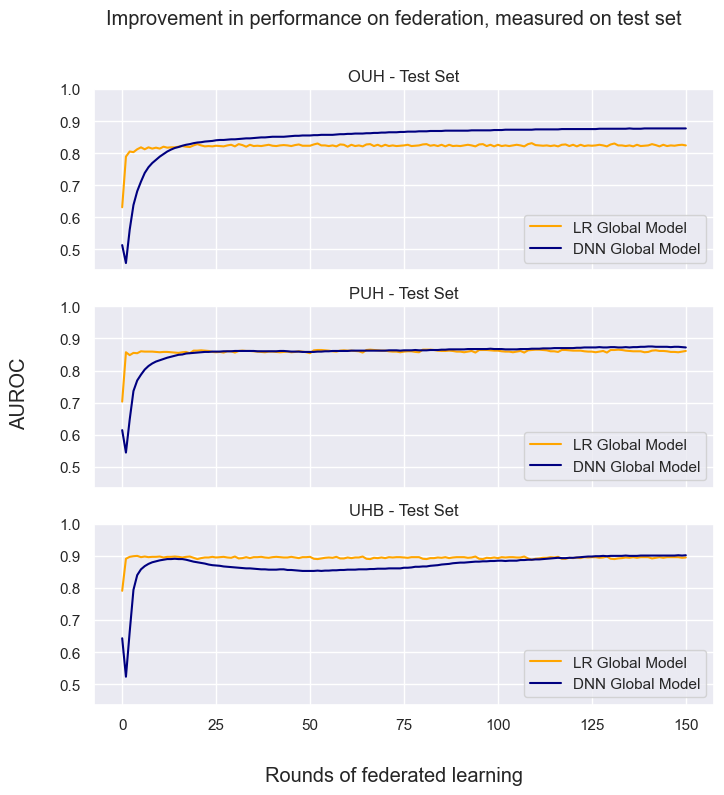

In [120]:
#Repeat plotting of AUROC versus round of FL ON THE TEST SET to show benefit of FL on the test set

#Load in Results Files
LRFederationCurves = pd.read_csv(basepath+"LR Test Set Evaluation - Results collated on server.csv", index_col=0, header=[0,1])
DNNFederationCurves = pd.read_csv(basepath+"DNN Test Set Evaluation - Results collated on server.csv", index_col=0, header=[0,1])

#Cycle through the sites to split out the AUROC column in to AUC, _lower95 and _upper95
for name, resultsSheet in enumerate([LRFederationCurves, DNNFederationCurves]):
    for site in ['OUH','PUH','UHB']:
        try:
            resultsSheet[site,'AUROC'], resultsSheet[site,'AUROC_lower95'], resultsSheet[site,'AUROC_upper95'], resultsSheet[site,'AUROC_formatted'] = AUCSplitter(resultsSheet[site,'AUROC'])
        except:
            print ('Not all sites in all results files')
    resultsSheet.sort_index(axis=1, level=0, inplace=True)

sites = ['OUH','PUH','UHB']
outputDf = pd.DataFrame(index=DNNGlobalFederationResults.index)

for site in sites:    
    #First place LR results for Global Model
    outputDf[site+' Global Model LR (AUROC)'] = LRFederationCurves[site,'AUROC']
    outputDf[site+' Global Model LR (AUROC)_u95'] = LRFederationCurves[site,'AUROC_upper95']
    outputDf[site+' Global Model LR (AUROC)_l95'] = LRFederationCurves[site,'AUROC_lower95']
    
    #Next place DNN results for Global Model
    outputDf[site+' Global Model DNN (AUROC)'] = DNNFederationCurves[site,'AUROC']
    outputDf[site+' Global Model DNN (AUROC)_u95'] = DNNFederationCurves[site,'AUROC_upper95']
    outputDf[site+' Global Model DNN (AUROC)_l95'] = DNNFederationCurves[site,'AUROC_lower95']
    
#Save results
outputDf.to_csv('23-12-22 Plot of Federation Curves on Test Set.csv')
testSetFederationCruves = outputDf

#Plot Federation Curves for Test Set
sns.set()
sns.color_palette("muted")
fig, axes = plt.subplots(3, sharey=True, sharex=True, figsize=(8,8))
fig.suptitle('Improvement in performance on federation, measured on test set')
fig.supylabel('AUROC')
fig.supxlabel('Rounds of federated learning')

#Plot OUH
sns.lineplot(ax=axes[0], x=testSetFederationCruves.index.values, y=testSetFederationCruves['OUH Global Model LR (AUROC)'].values, color='orange', label="LR Global Model")
sns.lineplot(ax=axes[0], x=testSetFederationCruves.index.values, y=testSetFederationCruves['OUH Global Model DNN (AUROC)'].values, color='navy', label="DNN Global Model")

#Plot PUH
sns.lineplot(ax=axes[1], x=testSetFederationCruves.index.values, y=testSetFederationCruves['PUH Global Model LR (AUROC)'].values, color='orange', label="LR Global Model")
sns.lineplot(ax=axes[1], x=testSetFederationCruves.index.values, y=testSetFederationCruves['PUH Global Model DNN (AUROC)'].values, color='navy', label="DNN Global Model")

#Plot UHB
sns.lineplot(ax=axes[2], x=testSetFederationCruves.index.values, y=testSetFederationCruves['UHB Global Model LR (AUROC)'].values, color='orange', label="LR Global Model")
sns.lineplot(ax=axes[2], x=testSetFederationCruves.index.values, y=testSetFederationCruves['UHB Global Model DNN (AUROC)'].values, color='navy', label="DNN Global Model")

plt.xticks(np.arange(0, 151, step=25))
plt.yticks(np.arange(0.5, 1.05, step=0.1))
axes[0].set_title("OUH - Test Set")
axes[1].set_title("PUH - Test Set")
axes[2].set_title("UHB - Test Set")
for ax in axes:
    ax.legend(loc='lower right')

fig.savefig('23-12-22 Supplementary Figure S1 Test Set Federation Curves.png', dpi=500)